# Milestone 2
This notebook aims to delve into and elucidate the pertinent aspects of our datasets, pre-process them in advance, and conduct a preliminary analysis. The initial part encompasses loading the data and incorporates various general preprocessing techniques. The subsequent part encapsulate the preliminary analyses conducted, providing insights into the viability and soundness of our chosen idea.

---
## Contents of notebook:
- [Part 1: Getting Familiar with the Data](#Part-1:-Getting-Familiar-with-the-Data)
    - [Loading the Data](#Loading-the-Data)
    - [Merging the Data](#Merging-the-Data)
---

## Part 1: Getting Familiar with the Data

In [2]:
import pandas as pd
from datetime import datetime as dt
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import ast

### Loading the Data

In [6]:
# Dataset Path
movies_path = '../MovieSummaries/movie.metadata.tsv'

# Column Names
movies_names = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "movie_name",
    "movie_release_date",
    "movie_box_office_revenue",
    "movie_runtime",
    "movie_languages",
    "movie_countries",
    "movie_genres",
]

#Year for the analysis
first_year = 1992
last_year = 2012


# Dataframe
movies_df = pd.read_csv(movies_path, sep = "\t", header = None, names = movies_names)

# Dataframe Cleaning 
movies_df["movie_release_date"] = pd.to_datetime(movies_df["movie_release_date"], errors = "coerce")
movies_df = movies_df[movies_df["movie_release_date"].dt.year.between(first_year, last_year)]

# I think this removes too much potential candidates from the pool, as we get the revenues later on anyways (which is where we should actually remove the NA values I think)
# movies_df = movies_df[movies_df["movie_box_office_revenue"].notna()]


In [7]:
# This function transforms the data in the given input (assumed to be a string containing a dictionary like object) into a list of the values contained in the dictionary like object
def dictionary_string_to_list(input):
    res = []
    for value in (ast.literal_eval(input)).values():
        res += [value]
    return res

# We appply the above function iteratively to the genres, countries and languages columns
movies_df["movie_genres"] = movies_df["movie_genres"].apply(dictionary_string_to_list)

# We also filter to keep only the films that were shown in the USA
movies_df["movie_countries"] = movies_df["movie_countries"].apply(dictionary_string_to_list)
movies_df = movies_df[movies_df['movie_countries'].apply(lambda list : "United States of America" in list)]

movies_df["movie_languages"] = movies_df["movie_languages"].apply(dictionary_string_to_list)

# I think we should keep those columns
# movies_df = movies_df.drop(columns = ["movie_languages", "movie_countries"])

# But drop these
movies_df = movies_df.drop(columns = ["wikipedia_movie_ID", "freebase_movie_ID"])

display(movies_df)

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
12,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,..."
19,Keep the Change,1992-01-01,NaN,97.0,[English Language],[United States of America],[Drama]
21,New Rose Hotel,1999-10-01,21521.0,92.0,[English Language],[United States of America],"[Thriller, Science Fiction, Future noir, Indie..."
...,...,...,...,...,...,...,...
81714,Dot.Kill,2005-01-01,NaN,90.0,[],[United States of America],"[Thriller, Crime Thriller, Action, Psychologic..."
81716,The Kreutzer Sonata,2008-01-01,NaN,99.0,[],[United States of America],"[Romantic drama, Romance Film, Drama, Film ada..."
81725,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]","[Parody, Americana, Comedy]"
81726,Guilty as Sin,1993-06-04,22886222.0,107.0,[],[United States of America],"[Thriller, Erotic thriller, Psychological thri..."


In [11]:
# Dataset Path
usBoxOffice_path = "./boxofficemojo_august_2019.csv"

# Column Names
usBoxOffice_names = [
    "rank",
    "movie_name",
    "studio",
    "domestic_movie_box_office_revenue",
    "year",
]

# Dataframe
usBoxOffice_df = pd.read_csv(usBoxOffice_path, sep = ",", header = 0, names = usBoxOffice_names)

# Dataframe Cleaning
usBoxOffice_df = usBoxOffice_df[usBoxOffice_df["year"].between(first_year, last_year)]
usBoxOffice_df = usBoxOffice_df.drop(columns = ["rank", "studio", "year"])

display(usBoxOffice_df)

,movie_name,domestic_movie_box_office_revenue
2,Avatar,760507625
5,Titanic,659363944
7,Marvel's The Avengers,623357910
10,The Dark Knight,535234033
14,Star Wars: Episode I - The Phantom Menace,474544677
...,...,...
16530,Playback,264
16533,"Pretty Village, Pretty Flame",211
16536,The Objective,95
16537,Dog Eat Dog,80


### Merging the Data
As the Box Office Mojo dataset solely features movie titles without any corresponding identification, we merged it with the CMU Movie Summary Corpus Dataset using the common identifier of movie_name. This merged dataset now incorporates details regarding the U.S. domestic box office revenue, a crucial element for our analytical endeavors.

In [12]:
# Dataframes Merge
movies_df = pd.merge(
    left = movies_df,
    right = usBoxOffice_df,
    how = "left",
    on = ["movie_name"],
)
movies_df = movies_df[movies_df["domestic_movie_box_office_revenue"].notna()]

display(movies_df)

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,domestic_movie_box_office_revenue
4,New Rose Hotel,1999-10-01,21521.0,92.0,[English Language],[United States of America],"[Thriller, Science Fiction, Future noir, Indie...",21521.0
5,White on Rice,2009-01-01,NaN,82.0,[],[United States of America],"[Romantic comedy, Romance Film, Comedy, Indie]",69171.0
6,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",28734552.0
11,The Great New Wonderful,2006-06-23,172055.0,87.0,[English Language],[United States of America],"[Drama, Ensemble Film, Comedy-drama, Indie]",150142.0
25,Things to Do in Denver When You're Dead,1995-10-01,529677.0,115.0,[English Language],[United States of America],"[Thriller, Crime Fiction, Crime Comedy, Gangst...",529766.0
...,...,...,...,...,...,...,...,...
13742,Twister,1996-05-10,494471524.0,113.0,[English Language],[United States of America],"[Action/Adventure, Disaster]",241721524.0
13743,Source Code,2011-03-11,147332697.0,93.0,[English Language],"[France, United States of America]","[Thriller, Science Fiction, Action/Adventure, ...",54712227.0
13744,How to Eat Fried Worms,2006-08-25,13040527.0,98.0,[English Language],[United States of America],"[Family Film, Drama, Comedy, Film adaptation]",13040527.0
13750,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]","[Parody, Americana, Comedy]",6944471.0


### Dealing with columns that have multiple values
Then, we create a dataframe handling the genres, countries and languages columns in the data, in order to make them easier to handle in the future. This is achieved by creating a 'dummy' version for each of these variables.

### Work in progress here

In [13]:
# We need to define the dummy variables not for each possible list containing genres, but for genres within said lists. This function handles this added layer. 
def define_dummy_variables(df, column):
    series = df[column]
    result = pd.get_dummies(series.apply(pd.Series).stack()).sum(level=0)
    return result

Genres_df = define_dummy_variables(movies_df, 'movie_genres')
Countries_df = define_dummy_variables(movies_df, 'movie_countries')
Language_df = define_dummy_variables(movies_df, 'movie_languages')

C:\Users\PC\AppData\Local\Temp\ipykernel_13048\2991507986.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = pd.get_dummies(series.apply(pd.Series).stack()).sum(level=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_13048\2991507986.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  result = pd.get_dummies(series.apply(pd.Series).stack()).sum(level=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_13048\2991507986.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  result = pd.get_dummies(series.apply(pd.Series).stack()).sum(level=0)
C:\Users\PC\AppData

,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,Adult,Adventure,Adventure Comedy,...,Vampire movies,War film,Werewolf fiction,Western,Whodunit,Workplace Comedy,World History,World cinema,Wuxia,Zombie Film
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
for i in list(Genres_df.columns):
    print(i, Genres_df[i].sum())

Absurdism 35
Acid western 1
Action 946
Action Comedy 51
Action Thrillers 107
Action/Adventure 698
Addiction Drama 13
Adult 2
Adventure 596
Adventure Comedy 37
Airplanes and airports 15
Albino bias 6
Alien Film 19
Americana 39
Animal Picture 52
Animals 7
Animated Musical 10
Animated cartoon 3
Animation 169
Anime 6
Anthropology 1
Anti-war 5
Anti-war film 5
Apocalyptic and post-apocalyptic fiction 10
Archives and records 6
Art film 6
Auto racing 11
Avant-garde 17
B-movie 11
Baseball 3
Beach Film 2
Biker Film 1
Biographical film 145
Biography 297
Biopic [feature] 71
Black comedy 270
Black-and-white 17
Blaxploitation 6
Bloopers & Candid Camera 3
Bollywood 1
Boxing 21
British Empire Film 2
Buddy cop 5
Buddy film 149
Business 9
Caper story 24
Chase Movie 28
Childhood Drama 29
Children's 89
Children's Fantasy 68
Children's/Family 202
Chinese Movies 29
Christian film 29
Christmas movie 26
Combat Films 9
Comedy 2037
Comedy Thriller 21
Comedy Western 4
Comedy film 64
Comedy horror 1
Comedy of Err

In [28]:

# testo['fuse'] = testo[['Comedy', 'Coming of age']].max(axis='columns')


aggregation_method = {
    'Western' : ['Western'],
    'Action' : ['Action'],
    'Comedy' : ['Comedy'],
    'Thrillers' : ['Thrillers'],
    'Adventure' : ['Adventure'],
    'Drama' : ['Drama'],
    'Musical' : ['Musical'],
    'Animation' : ['Animated', 'Anime', 'Animation'],
    'History' : ['Archive', 'History'],
    'Biography' : ['Biopic', 'Biographical', 'Biography'],
    'Sports' : ['Sports'],
    'Fantasy' : ['Fantasy'],
    'Indie' : ['Indie'],
    'Mystery' : ['Mystery'],
    'Parody' : ['Satire', 'Parody'],
    'Romance' : ['Romantic', 'Romance'],
    'Science-Fiction' : ['Sci-Fi', 'Science-Fiction'] 
}

Genres_aggregated_df = Genres_df[['Documentary']]

,Comedy,Coming of age,fuse
4,0,0,0
5,1,0,1
6,0,1,1
11,0,0,0


### Analysis of the box office through the years
We take a look at what the revenue distribution for movie looks like for our filtered dataset. 

In [71]:
stats = movies_df['domestic_movie_box_office_revenue'].describe()
    
# Print the statistics
print(" Box office descriptive Statistics:")
print(stats)

 Box office descriptive Statistics:
count    5.091000e+03
mean     2.932998e+07
std      5.337477e+07
min      3.000000e+01
25%      2.955880e+05
50%      8.008255e+06
75%      3.563219e+07
max      7.605076e+08
Name: domestic_movie_box_office_revenue, dtype: float64


[Text(0.5, 1.0, 'Revenue distribution')]

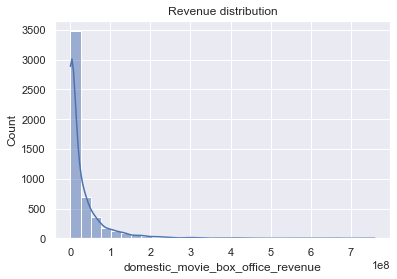

In [66]:
# Compute the distribution for our movie datasets in terms of box office revenues
sns.histplot(movies_df["domestic_movie_box_office_revenue"], bins=30, kde=True).set(title = 'Revenue distribution')


However, we see that our distribution is extremely skewed : we have a long tailed distribution. As such, it seems interesting to take a look at our data using a log plot for our x-axis to get a better idea of the way movies are spread in terms of revenues. 

[Text(0.5, 1.0, 'Revenue distribution')]

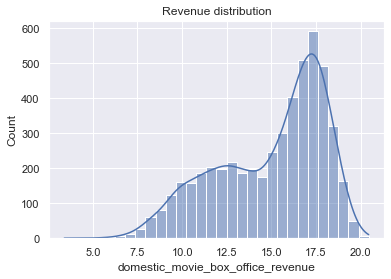

In [63]:
#PLot the distribution for the log normalized box offices 
sns.histplot(np.log(movies_df["domestic_movie_box_office_revenue"]), bins=30, kde=True).set(title = 'Revenue distribution')
# Not sure about this
# plt.xscale('log')

In [72]:
# Describe the box office revenue per year
for year in range(first_year, last_year+1):
    # Calculate descriptive statistics for each column
    stats = movies_df[movies_df["movie_release_date"].dt.year == year]["domestic_movie_box_office_revenue"].describe()
    
    # Print the statistics
    print(f"{year} Descriptive Statistics:")
    print(stats)
    print("\n" + "-"*65 + "\n")

1992 Descriptive Statistics:
count    1.700000e+02
mean     2.776255e+07
std      4.106705e+07
min      1.100000e+03
25%      1.675486e+06
50%      1.281070e+07
75%      3.170680e+07
max      2.173502e+08
Name: domestic_movie_box_office_revenue, dtype: float64

-----------------------------------------------------------------

1993 Descriptive Statistics:
count    1.860000e+02
mean     2.465129e+07
std      4.246170e+07
min      1.836900e+04
25%      2.802671e+06
50%      1.092577e+07
75%      3.171260e+07
max      4.028281e+08
Name: domestic_movie_box_office_revenue, dtype: float64

-----------------------------------------------------------------

1994 Descriptive Statistics:
count    1.930000e+02
mean     2.589903e+07
std      4.922593e+07
min      1.166900e+04
25%      2.694234e+06
50%      1.042464e+07
75%      2.505200e+07
max      4.227838e+08
Name: domestic_movie_box_office_revenue, dtype: float64

-----------------------------------------------------------------

1995 Descript

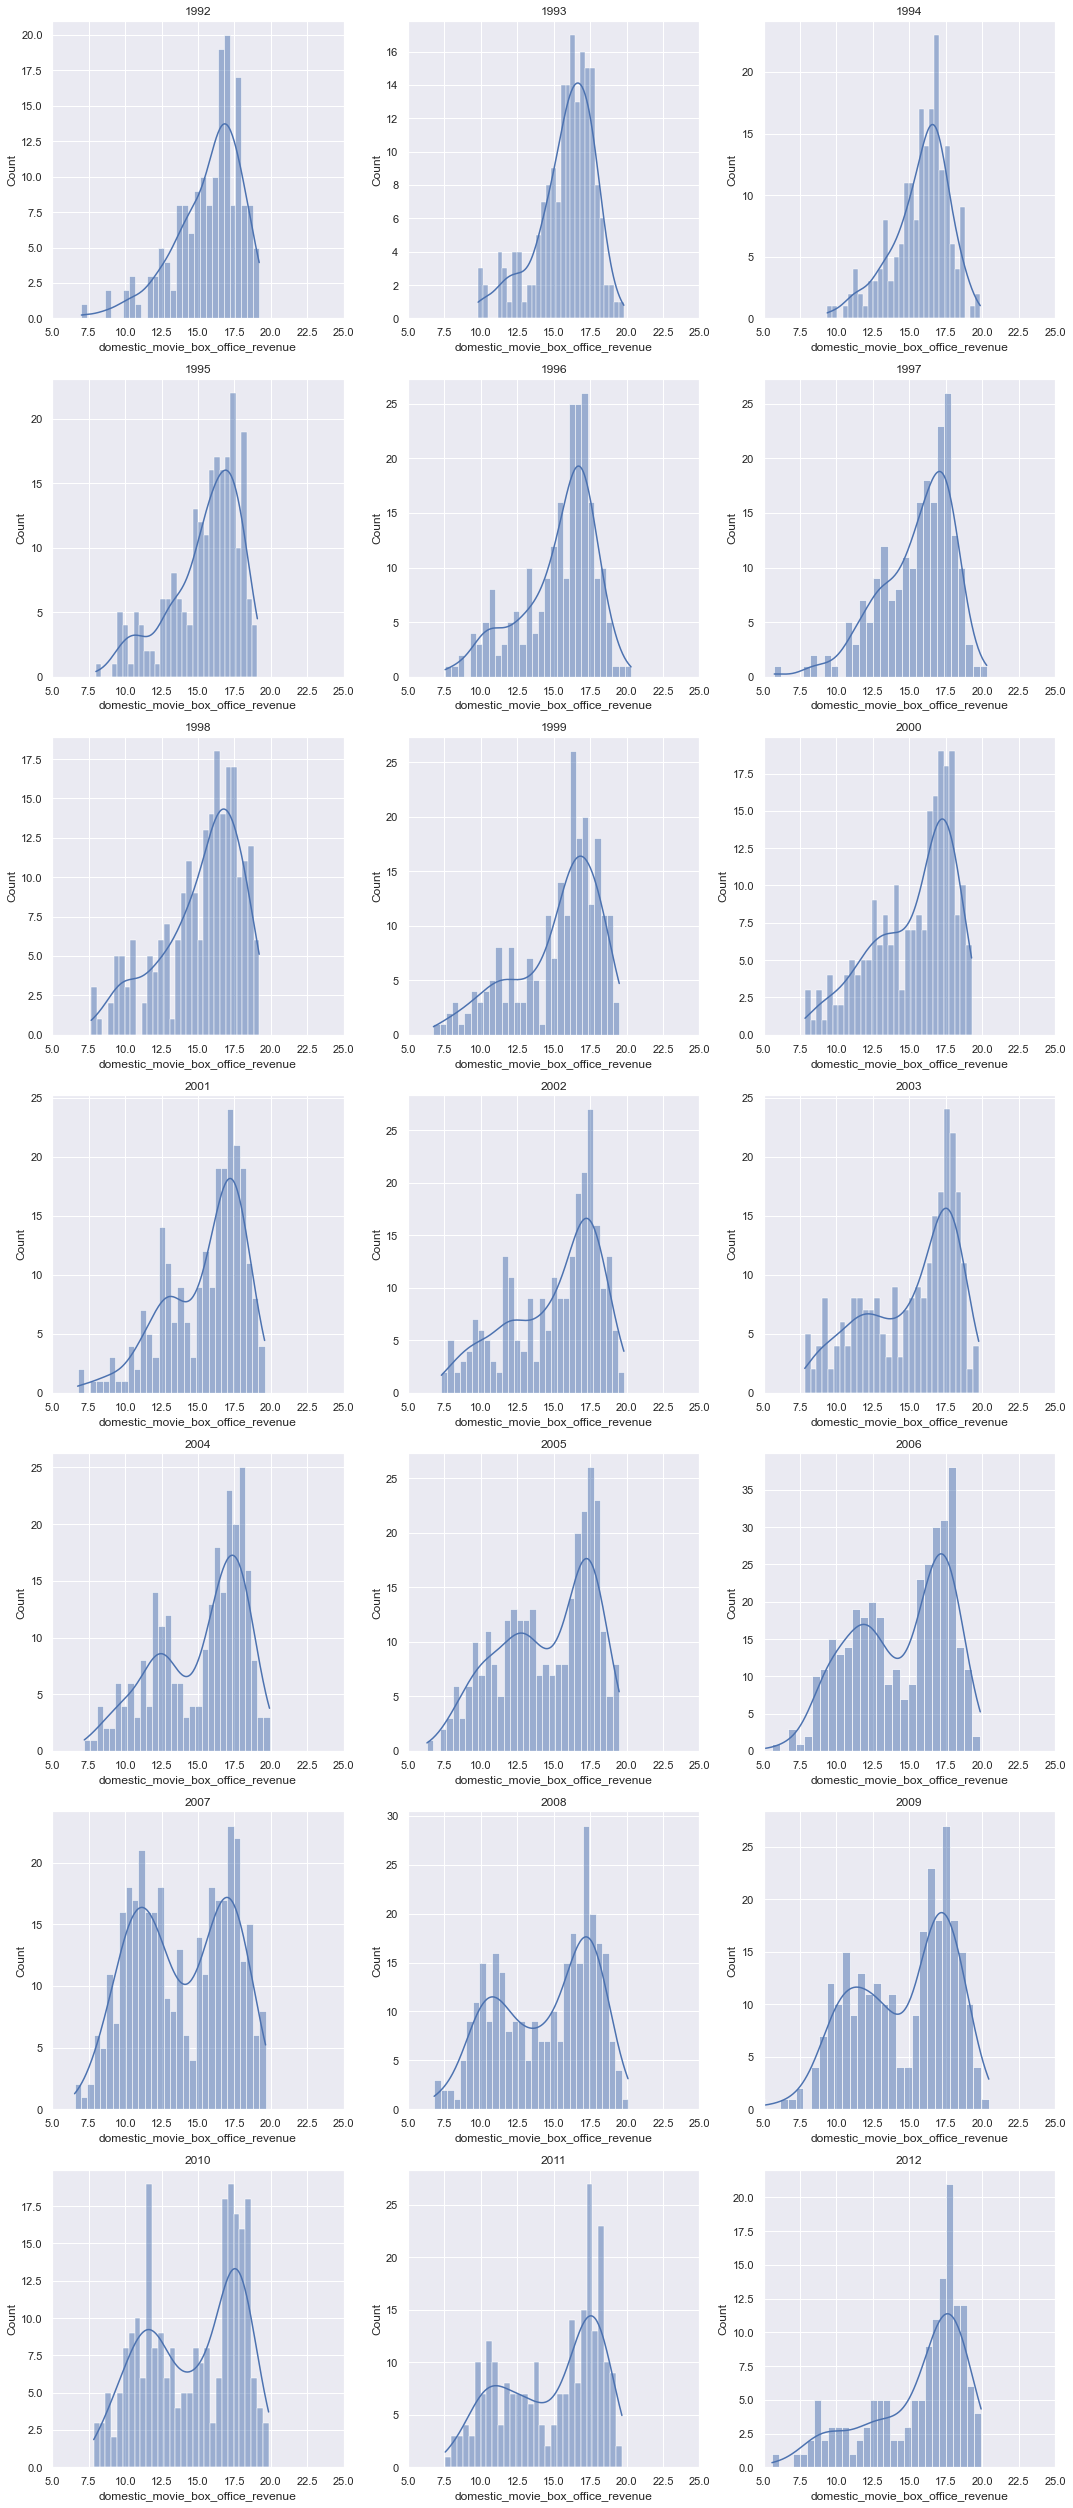

In [67]:
sns.set(style="darkgrid")


# We have 21 years of data for our choice of analysis, so we showcase 3 years per row
n_rows = 7
n_cols = 3

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Plot the box office distribution for each year of our analysis
for year in range(first_year, last_year + 1):
    position = year - first_year
    row = position//3
    col = position%3
    ax = axes[row, col]
    ax.set_xlim(5,25)
    
    sns.histplot(np.log(movies_df[movies_df["movie_release_date"].dt.year == year]["domestic_movie_box_office_revenue"]), bins=30, ax=ax, kde=True)
    ax.set_title(f'{year}')

plt.tight_layout()
plt.show()

We notice that, overall, the mean tends to increase throughout the year. The issue currently is that this analysis does not factor in the inflation rate, which means that the data is skewed for older movies. To correct this effect, we add a column to our dataset to include the inflation corrected box offices.
There is no perfect method to account for this inflation rate, as many elements must be considered (prices of the tickets vs the inflation rate namely, types of tickets used and so on). The method selected here is to use the mean inflation rate between the release year X and the year 2012 (since this is the last year of our dataset). In practice, this corresponds to what a dollar in year X would be worth in 2012.


In [49]:
inflation_rates_df = pd.read_csv('./Inflation rate.csv', index_col='Year', sep=';', decimal=',')

# This function allow us to get the inflation rate for a given year
def get_inflation_rate(year):
    return inflation_rates_df.loc[year]['Factor']

# Multiply the inflation rate for the release year by the box office to compute the inflation corrected value
movies_df['Inflation_corrected_box_office'] = movies_df['movie_release_date'].dt.year.apply(get_inflation_rate) * movies_df['domestic_movie_box_office_revenue']

With this new column, we repeat the analysis from before to get a better idea of the actual box office distribution

In [74]:
stats = movies_df['Inflation_corrected_box_office'].describe()
    
# Print the statistics
print(" Box office descriptive Statistics:")
print(stats)

 Box office descriptive Statistics:
count    5.091000e+03
mean     3.720247e+07
std      6.702473e+07
min      3.480000e+01
25%      3.803907e+05
50%      1.067481e+07
75%      4.534297e+07
max      9.824523e+08
Name: Inflation_corrected_box_office, dtype: float64


[Text(0.5, 1.0, 'Inflation corrected revenue distribution')]

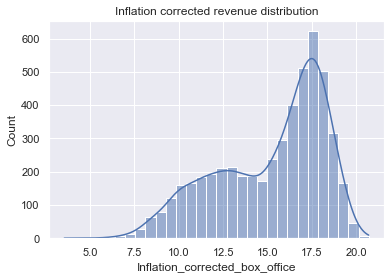

In [62]:
# Compute the distribution for our movie datasets in terms of box office revenues
sns.histplot(np.log(movies_df["Inflation_corrected_box_office"]), bins=30, kde=True).set(title = 'Inflation corrected revenue distribution')


In [73]:
# Describe the box office revenue corrected for inflation per year
for year in range(first_year, last_year+1):
    # Calculate descriptive statistics for each column
    stats = movies_df[movies_df["movie_release_date"].dt.year == year]["Inflation_corrected_box_office"].describe()
    
    # Print the statistics
    print(f"{year} Descriptive Statistics:")
    print(stats)
    print("\n" + "-"*65 + "\n")

1992 Descriptive Statistics:
count    1.700000e+02
mean     4.608583e+07
std      6.817131e+07
min      1.826000e+03
25%      2.781307e+06
50%      2.126575e+07
75%      5.263329e+07
max      3.608014e+08
Name: Inflation_corrected_box_office, dtype: float64

-----------------------------------------------------------------

1993 Descriptive Statistics:
count    1.860000e+02
mean     3.968858e+07
std      6.836333e+07
min      2.957409e+04
25%      4.512300e+06
50%      1.759049e+07
75%      5.105729e+07
max      6.485533e+08
Name: Inflation_corrected_box_office, dtype: float64

-----------------------------------------------------------------

1994 Descriptive Statistics:
count    1.930000e+02
mean     4.066148e+07
std      7.728471e+07
min      1.832033e+04
25%      4.229947e+06
50%      1.636669e+07
75%      3.933164e+07
max      6.637705e+08
Name: Inflation_corrected_box_office, dtype: float64

-----------------------------------------------------------------

1995 Descriptive Stati

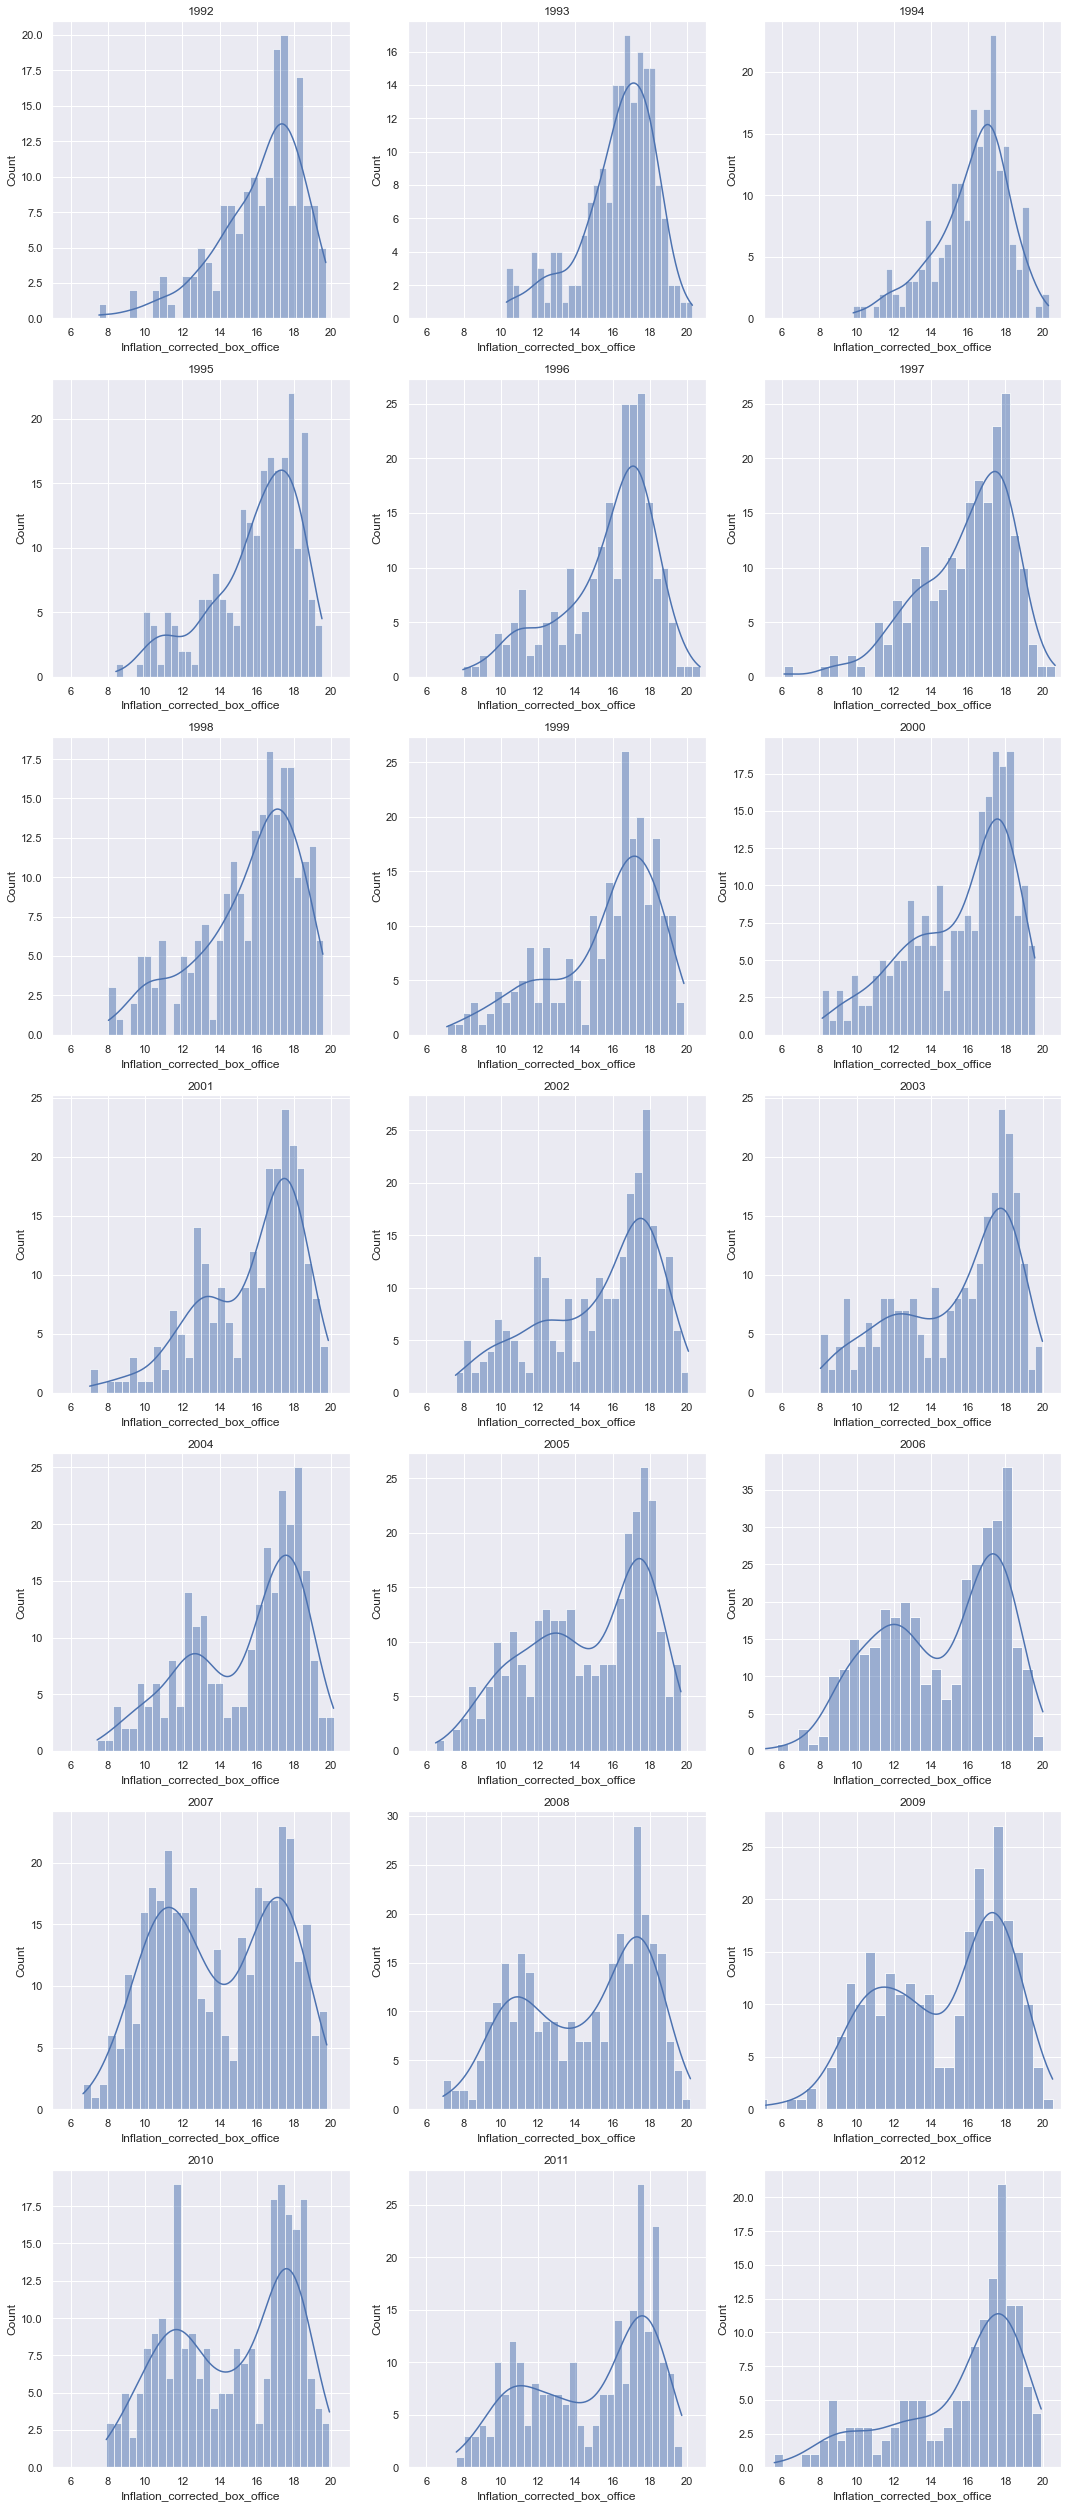

In [69]:
sns.set(style="darkgrid")


# We have 21 years of data for our choice of analysis, so we showcase 3 years per row
n_rows = 7
n_cols = 3

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Plot the box office distribution for each year of our analysis
for year in range(first_year, last_year + 1):
    position = year - first_year
    row = position//3
    col = position%3
    ax = axes[row, col]
    ax.set_xlim(5,21)
    
    sns.histplot(np.log(movies_df[movies_df["movie_release_date"].dt.year == year]["Inflation_corrected_box_office"]), bins=30, ax=ax, kde=True)
    ax.set_title(f'{year}')

plt.tight_layout()
plt.show()